<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.5.2-LSTMB16-GloVe-500k-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained embedding using LSTM

We are debugging our deep learning network. We think there might be some issues with our embedding layer of the network. 

In this notebook, we will use pre-trained embedding (GloVe) for our embedding layer and see how our network performs.

For speed of iterations, we will use 16 LSTM units in our architecture since in our previous sets of notebooks, the number of LSTM nodes did not affect our score very much.

We will use 500k samples in this notebook

## Embedding
You can download GloVe embedding here: https://nlp.stanford.edu/projects/glove/

We will be using the 840B dataset since that has the most comprehensive vocabulary.

Length of our embedding vector will be 300 - this is same as our random embedding

The embedding matrix will be created based on the training set so that we can have a more accurate sense of how the embedding space will perform on new reviews.

For further documentation on how to use pre-trained embedding, please refer to this doc: https://keras.io/examples/pretrained_word_embeddings/


# Result

For our random embedding LSTM model with 16 units, our score was: 0.3849584800258859

Using GloVe, our score is: 0.32439214411478845 - we are still performing below our random embedding mode.

Next notebook will be with 1 million examples to see if we see the same behavior as before where performance starts to decrease as we increase more examples



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


LSTM_DIM = 16 # total LSTM units
MODEL_NAME = f"LSTMB{LSTM_DIM}_glove"
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units, No Dropout, GloVe Embedding, Balanced Weights"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 4

SAMPLES = "500k"

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-preprocessed.csv"
  MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
  ku.ModelWrapper.set_report_filename('glove_embedding-dl_prototype-report.csv')


EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'

# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100




In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [4]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer(oov_token="<UNK>")
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=73964
Number of Documents=373376
Train review vectors shape: (373376, 100)  Test review vectors shape: (124459, 100)


## Load our pre-trained embedding

embeddings_index will be a map where key == word, value == the embedding vector

In [5]:
print('Indexing word vectors.')

embeddings_index = {}
with open(EMBEDDING_FILE) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 2195884 word vectors.


## Create Embedding Matrix based on our tokenizer

For every word in our vocabulary, we will look up the embedding vector and add the it to our embedding matrix

The matrix will be passed in as weights in our embedding layer later

If there is word that does not exist in the pre-trained embedding vocabulary, we will leave the weights as 0 vector and save off the word into a CSV file later for analysis

In [6]:
# this is a map with key == word, value == index in the vocabulary
word_index = t.word_index
print(f'word_index length: {len(word_index)}')

# we are going to use the entire vocab so we can alter this from the example
# num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

# start with a matrix of 0's
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

# if a word doesn't exist in our vocabulary, let's save it off
missing_words = []
print(f'embedding_matrix shape: {np.shape(embedding_matrix)}')
for word, i in word_index.items():
    # print(f'word: {word} i: {i}')
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and np.shape(embedding_vector)[0] == EMBED_SIZE:
        # words not found in embedding index will be all-zeros.
        # print(f'i: {i} embedding_vector shape: {np.shape(embedding_vector)}')
        embedding_matrix[i] = embedding_vector
    else:
      missing_words.append(word)

print(f'Number of missing words from our vocabulary: {len(missing_words)}')



word_index length: 73965
embedding_matrix shape: (73966, 300)
Number of missing words from our vocabulary: 26049


Save off our missing words into a csv file so we can analyze this later

In [0]:
# save missing words into a file so we can analyze it later
missing_words_df = pd.DataFrame(missing_words)
missing_words_df.to_csv(MISSING_WORDS_FILE, index=False)

**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_index)+1

# building our network
model = Sequential()
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
model.add(Embedding(input_dim=vocab_size,
                            output_dim=EMBED_SIZE,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
# model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(LSTM_DIM))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [9]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          22189800  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                20288     
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 22,210,173
Trainable params: 20,373
Non-trainable params: 22,189,800
_________________________________________________________________
None


In [10]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                            #   factor=0.4,
                            #   patience=PATIENCE, 
                            #   min_lr=0.00001,
                            #  mode='auto',
                              restore_best_weights=True)

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.41902061 3.0309589  2.20828158 1.20167276 0.37308618]
Number of training examples: 373376
Train on 298700 samples, validate on 74676 samples
Epoch 1/50
298700/298700 [==============================] - 35s 118us/sample - loss: 0.9097 - categorical_accuracy: 0.6500 - val_loss: 0.8383 - val_categorical_accuracy: 0.6712
Epoch 2/50
298700/298700 [==============================] - 27s 90us/sample - loss: 0.8199 - categorical_accuracy: 0.6806 - val_loss: 0.8038 - val_categorical_accuracy: 0.6849
Epoch 3/50
298700/298700 [==============================] - 27s 90us/sample - loss: 0.7947 - categorical_accuracy: 0.6890 - val_loss: 0.7906 - val_categorical_accuracy: 0.6898
Epoch 4/50
298700/298700 [==============================] - 27s 90us/sample - loss: 0.7808 - categorical_accuracy: 0.6943 - val_loss: 0.7837 - val_categorical_accuracy: 0.6933
Epoch 5/50
298700/298700 [==============================] - 27s 91us/sample - loss: 0.7711 - categorical_accuracy: 0.6977 - val_loss: 0.

Number of test: 124459
Running model.evaluate...
124459/124459 [==============================] - 20s 158us/sample - loss: 0.7759 - categorical_accuracy: 0.6948
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(124459, 5)
Getting classification report...
Accuracy: 69.48%


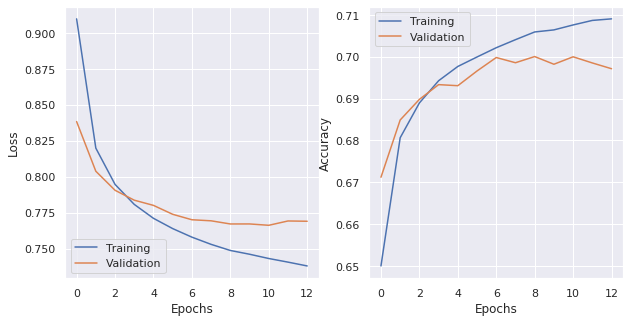


Confusion Matrix
[[14113  1089  1269   195   994]
 [ 3664  1187  2194   428   727]
 [ 1876   757  4144  2166  2360]
 [  561   167  2322  6346 11367]
 [  741   110  1025  3972 60685]]

Classification Report
              precision    recall  f1-score   support

           1       0.67      0.80      0.73     17660
           2       0.36      0.14      0.21      8200
           3       0.38      0.37      0.37     11303
           4       0.48      0.31      0.37     20763
           5       0.80      0.91      0.85     66533

    accuracy                           0.69    124459
   macro avg       0.54      0.51      0.51    124459
weighted avg       0.66      0.69      0.67    124459



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

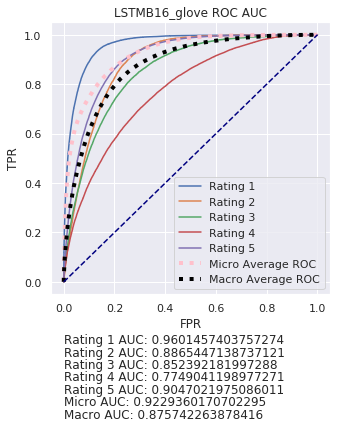

In [11]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [12]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.32439214411478845


**Save off various files**

In [13]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB16_glove-1x16-random_embedding-sampling_none-497835-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/LSTMB16_glove-1x16-random_embedding-sampling_none-497835-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/LSTMB16_glove-1x16-random_embedding-sampling_none-497835-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/LSTMB16_glove-1x16-random_embedding-sampling_none-497835-100-star_rating-weights.h5
Saving to report file: drive/My Drive/Springboard/capstone/reports/glove_embedding-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/glove_embedding-dl_prototype-report.csv
{'model_name': 'LSTMB16_glove', 'architecture': '1x16', 'description': '1 Layer 16 LSTM Units, No Dropout, GloVe Embedding, Balanced Weights', 'classification_report': '{"1": {"precision": 0.673490813648294, "recall": 0.7991506228765571, "f1-score": 0.73095

In [14]:
print(datetime.now())

2020-02-07 22:49:20.438139
